# Соревнование по Кластеризацию(К-Средние)

## Ссылка на соревнование

https://www.kaggle.com/competitions/urfuengaiml2022clustering

## Целевая метрика

F1 macro >= 0.9

## Dataset Description

**Файлы**  
* Data.csv - Набор данных
* Submission.csv - пример файла для загрузки решения
  
**Важно**  
* В качестве метрики выбрана F1 мера с Макроусреднением (f1_score)  
* Сразу оговоримся: порядки класстеров по убыванию размеров кластеров (т.е. самый большой кластер - с меткой 0, второй по размеру - с меткой 1, и так далее)  
* Чтобы проверить число экземпляров в кластере можно воспользоваться следующей строчкой кода (Submission – ДатаФрейм в котором есть столбец cluster куда сложены метки класса)

        Submission.cluster.value_counts()

* Чтобы изменить метки можно воспользоваться функцией map
* Например код ниже: для меток кластеров 0, 3, 4 и 5 – не выполняет замены, метки кластера 2 меняет на 1, метки кластера 1 меняет на два, метки кластера -1 меняет на 5.

        Submission.cluster = Submission.cluster.map({0 : 0, 2: 1, 1 : 2, 3:3, 4: 4, 5: 5, -1: 5})


### Import библиотек

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler

In [5]:
from sklearn.neighbors import KNeighborsClassifier

from sklearn.metrics import classification_report
from sklearn.model_selection import StratifiedKFold

from sklearn.metrics import confusion_matrix

from sklearn.metrics import accuracy_score as acc
from sklearn.metrics import f1_score as f1

In [6]:
import warnings 
warnings.simplefilter("ignore", UserWarning)

### Считываем файлы в DataFrame

In [7]:
df = pd.read_csv('./Data/Kaggle3/Data.csv', delimiter = ',', index_col='idx')
df.head(3)

,Признак 1,Признак 2,Признак 3,Признак 4,Признак 5
idx,,,,,
0,-0.179369,-0.013356,0.016641,-0.325923,-0.031094
1,-0.157893,-0.010647,0.002895,-0.332016,-0.012547
2,-0.249451,-0.011700,-0.001435,-0.487909,-0.005343


In [8]:
df.shape

(19033, 5)

### Первичный анализ данных

In [9]:
df.describe()

,Признак 1,Признак 2,Признак 3,Признак 4,Признак 5
count,1.903300e+04,1.903300e+04,1.903300e+04,1.903300e+04,1.903300e+04
mean,8.115804e-17,1.810235e-17,-7.680032e-17,3.016904e-16,5.529715e-17
std,5.372720e-01,6.612815e-02,6.395875e-02,4.809839e-01,5.676626e-02
min,-8.865561e-01,-4.705258e-02,-3.499009e-01,-5.417184e-01,-3.695438e-01
25%,-2.556412e-01,-1.392043e-02,-2.251187e-02,-4.636834e-01,-1.943088e-02
50%,-1.527072e-01,-9.348055e-03,3.760155e-03,-1.193854e-01,2.740698e-03
75%,1.387202e-01,-5.841646e-03,2.707801e-02,3.591970e-01,2.958351e-02
max,1.048308e+00,9.805234e-01,3.976242e-01,1.067578e+00,4.547306e-01


Типы данных в датасете

In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 19033 entries, 0 to 19920
Data columns (total 5 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Признак 1  19033 non-null  float64
 1   Признак 2  19033 non-null  float64
 2   Признак 3  19033 non-null  float64
 3   Признак 4  19033 non-null  float64
 4   Признак 5  19033 non-null  float64
dtypes: float64(5)
memory usage: 892.2 KB


Проверим датасет на пропуски значений

In [11]:
df.isnull().sum()

Признак 1    0
Признак 2    0
Признак 3    0
Признак 4    0
Признак 5    0
dtype: int64

Построим матрицу корреляций для числовых признаков

In [12]:
df.corr()

,Признак 1,Признак 2,Признак 3,Признак 4,Признак 5
Признак 1,1.000000e+00,1.868874e-16,-1.119823e-16,-3.780184e-16,-3.317671e-17
Признак 2,1.868874e-16,1.000000e+00,-2.426353e-16,-1.756725e-17,8.587204e-16
Признак 3,-1.119823e-16,-2.426353e-16,1.000000e+00,-2.827189e-17,-4.089498e-16
Признак 4,-3.780184e-16,-1.756725e-17,-2.827189e-17,1.000000e+00,2.437625e-17
Признак 5,-3.317671e-17,8.587204e-16,-4.089498e-16,2.437625e-17,1.000000e+00


### Проведем нормализацию датасета

In [13]:
col_names = df.columns
col_names

Index(['Признак 1', 'Признак 2', 'Признак 3', 'Признак 4', 'Признак 5'], dtype='object')

In [14]:
scaler  = MinMaxScaler()
scaler.fit_transform(df)
df = scaler.transform(df) 

In [15]:
df = pd.DataFrame(df, columns=col_names)
df.head(3)

,Признак 1,Признак 2,Признак 3,Признак 4,Признак 5
0,0.365497,0.032792,0.490341,0.134093,0.410604
1,0.376596,0.035428,0.471952,0.130307,0.433105
2,0.329276,0.034404,0.466159,0.033437,0.441844


In [16]:
# Как оказалось датасет уже был стандартизирован, но береженого бог бережет
# мы же его дополнительно нормализовали

### Построим графики взаимозависимостей переменных

По признаку 1

<Figure size 1080x1080 with 0 Axes>

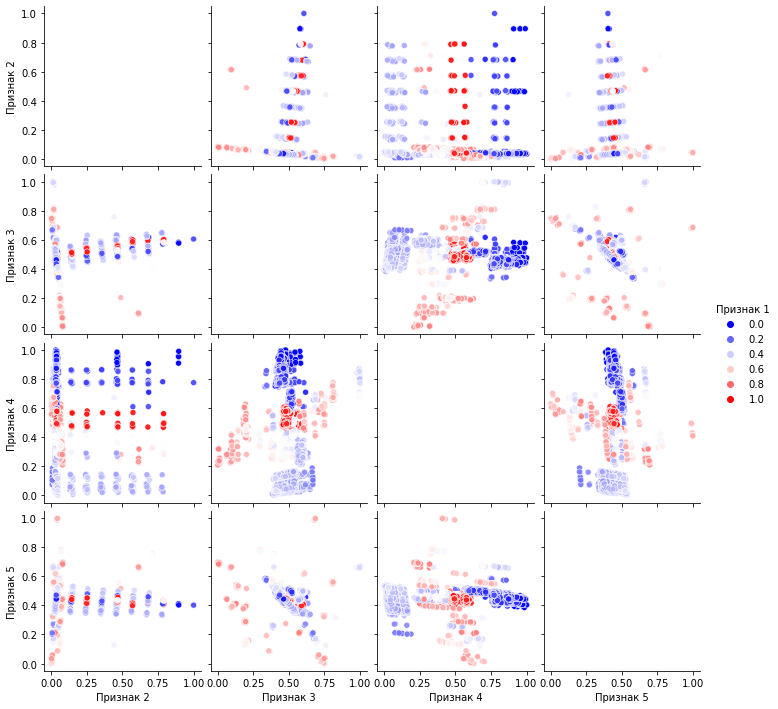

In [17]:
fig = plt.figure(figsize=(15,15))
sns.pairplot(data = df, 
             hue ='Признак 1',
             palette = 'bwr',);

По признаку 2

<Figure size 1080x1080 with 0 Axes>

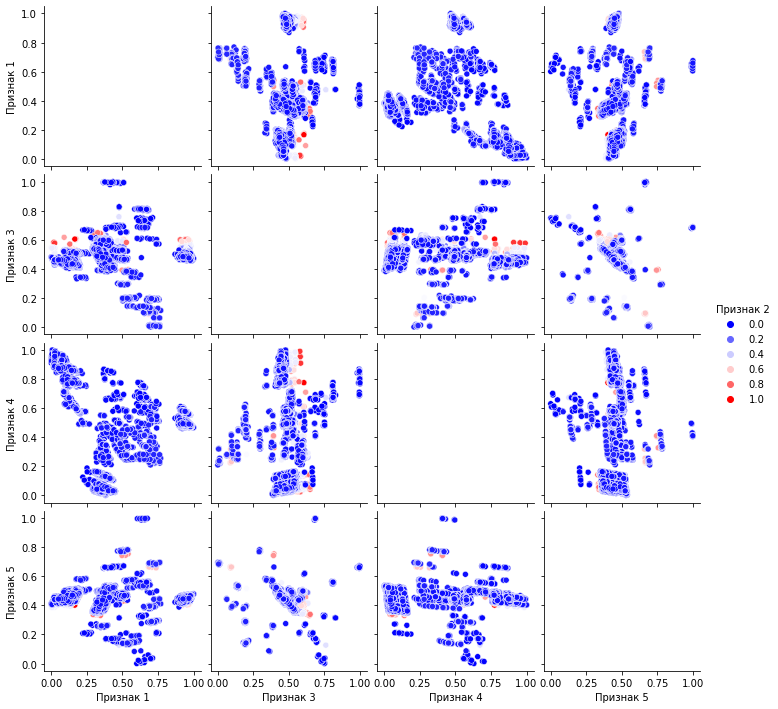

In [18]:
fig = plt.figure(figsize=(15,15))
sns.pairplot(data = df, 
             hue ='Признак 2',
             palette = 'bwr',);

По признаку 3

<Figure size 1080x1080 with 0 Axes>

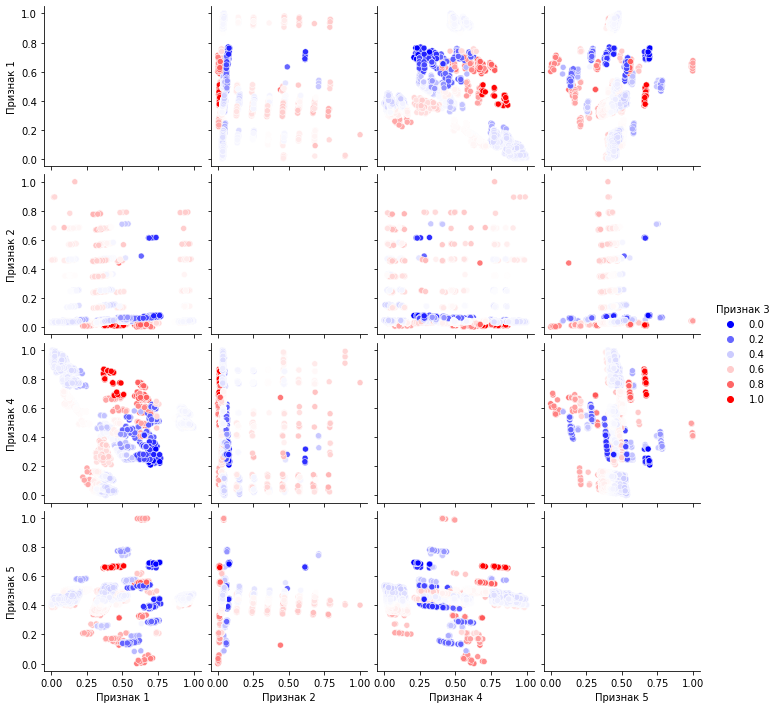

In [20]:
fig = plt.figure(figsize=(15,15))
sns.pairplot(data = df, 
             hue ='Признак 3',
             palette = 'bwr',);

По признаку 4

<Figure size 1080x1080 with 0 Axes>

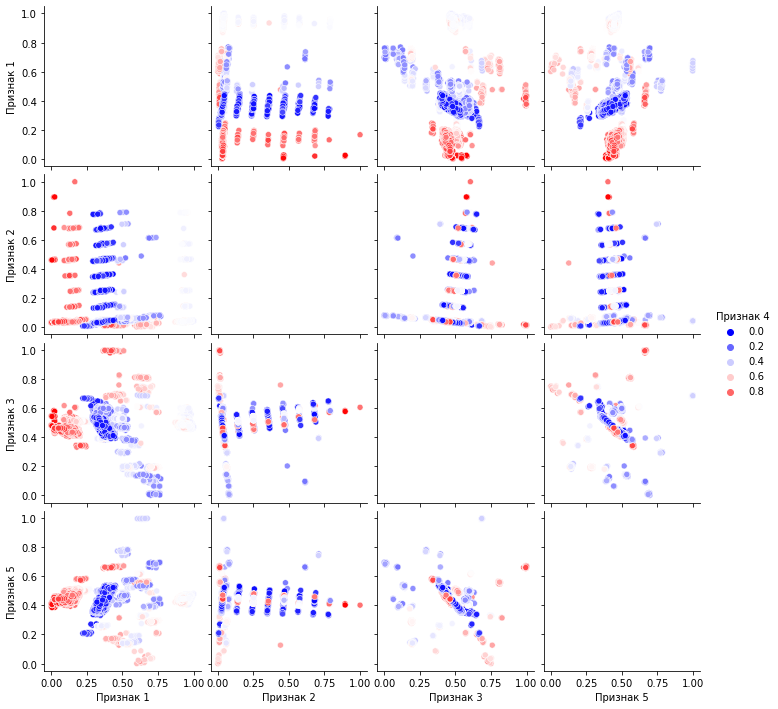

In [21]:
fig = plt.figure(figsize=(15,15))
sns.pairplot(data = df, 
             hue ='Признак 4',
             palette = 'bwr',);

По признаку 5

<Figure size 1080x1080 with 0 Axes>

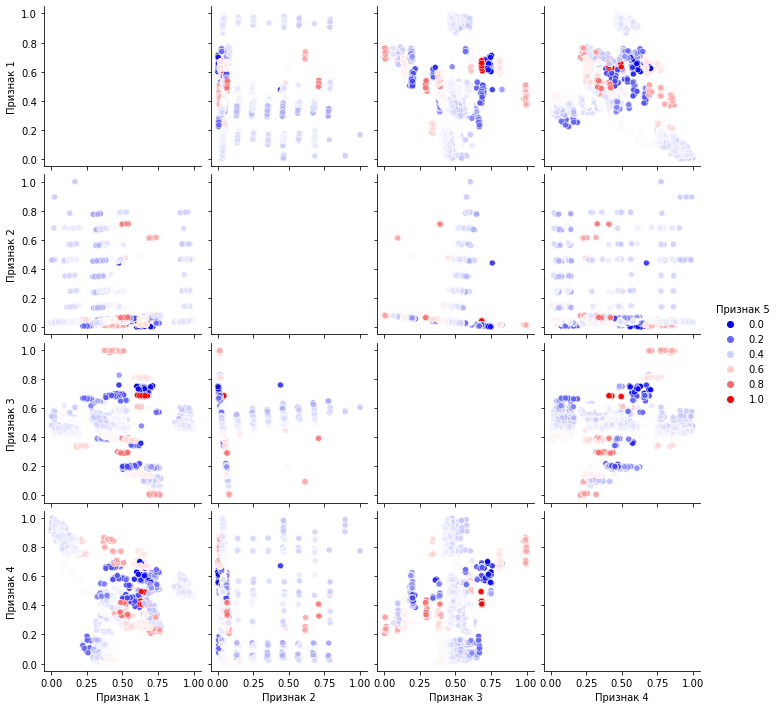

In [22]:
fig = plt.figure(figsize=(15,15))
sns.pairplot(data = df, 
             hue ='Признак 5',
             palette = 'bwr',);

*Долго, избыточно, но красиво.*
*Исходя из построенной визуализации выберем целевый признаки для построения модели*

**За целевую переменную волевым решением примем зависимость признаков: "Признак 1" и "Признак 4"**

### Необходимые функции (из лекционных блокнотов)

In [23]:
def plot_data(ax,ds,name='',marker = 'o',colors =("#FF0000", '#0000FF'),alpha=0.7, s = 150, facecolor=True):
    X, y = ds

    cm_bright = ListedColormap(colors)
    ax.set_title(name, fontsize = 30)
    if facecolor:
        ax.scatter(X[:, 0], X[:, 1],
                   marker = marker, c=y,
                   cmap=cm_bright,s = s,
                   alpha =alpha)
    else:
        ax.scatter(X[:, 0], X[:, 1],
                   marker = marker, c=y,
                   cmap=cm_bright,s = s,
                   facecolor = 'None',
                   alpha =alpha)

    x_min, x_max = X[:, 0].min() - .5, X[:, 0].max() + .5
    y_min, y_max = X[:, 1].min() - .5, X[:, 1].max() + .5
    ax.grid(True)
    ax.set_xlim(x_min, x_max)
    ax.set_ylim(y_min, y_max)
    ax.set_xticks(())
    ax.set_yticks(())

In [24]:
class KMeans():
    def __init__(self,n_clusters = 2, centroids = None,
                 max_iter=10, tol=0.01,
                 metric = 'euclidean', p = 2,
                 random_state = None):
        self.n_clusters = n_clusters
        self.centroids  = centroids
        self.max_iter   = max_iter        
        self.tol        = tol
        self.iters      = None
        self.inertia = None
        self.metric = metric
        self.p  = p
        self.random_state  = random_state
    #-------------------------------------    
    def distance(self,X1, X2):
        if self.metric == 'euclidean':
            dist = np.sqrt(np.sum(np.square(X1 - X2).T,axis=0))
        if self.metric == 'cityblock':
            dist = np.sum(np.abs(X1 - X2).T,axis=0)
        if self.metric == 'Chebyshev':
            dist = np.max(np.abs(X1 - X2).T,axis=0)  
        if self.metric == 'Minkowski':
            dist = np.power(np.sum(np.power(np.abs(X1 - X2),self.p).T,axis=0),1/self.p)      
        return dist
    #-------------------------------------
    def init_centroids(self, X):
        if self.random_state: rng = np.random.seed(self.random_state)
        c_idxs = np.random.randint(0, X.shape[0], size = self.n_clusters)
        return X[c_idxs,:]
    #-------------------------------------
    def predict(self, X):
        distances = np.zeros((X.shape[0], self.n_clusters))

        for i,centr in enumerate(self.centroids):
            distances[:,i] = self.distance(centr,X)
        self.inertia = np.sum(np.power(np.min(distances,axis = 1),2))
        return np.argmin(distances,axis = 1) 
    #-------------------------------------
    def transform(self,X):
        return self.predict(X)
    #-------------------------------------
    def delta_centroids(self,old_centroids):
        return (
                distance(self.centroids,old_centroids)/
                distance(old_centroids, np.mean(old_centroids))
               ).mean()
    #-------------------------------------
    def fit(self, X):
        
        if self.centroids is None:
            self.centroids = self.init_centroids(X)
    
        d_centrs = np.inf

        for i in range(self.max_iter):

            old_centroids = np.copy(self.centroids)
            
            cluster_label = self.predict(X)

            for k in range(self.n_clusters):
                
                c_idxs = np.flatnonzero(cluster_label==k)
                
                self.centroids[k] = X[c_idxs].mean(axis = 0)

            d_centrs = self.delta_centroids(old_centroids)

            self.iters = i
            if d_centrs<=self.tol:
                break
        return self        
    #-------------------------------------
    def fit_transform(self, X):
        return self.fit(X).predict(X)
    
    

In [25]:
def distance(X1, X2, metric = 'euclidean', p = 2):
    if metric == 'euclidean':
        dist = np.sqrt(np.sum(np.square(X1 - X2).T,axis=0))
    if metric == 'cityblock':
        dist = np.sum(np.abs(X1 - X2).T,axis=0)
    if metric == 'Chebyshev':
        dist = np.max(np.abs(X1 - X2).T,axis=0)  
    if metric == 'Minkowski':
        dist = np.power(np.sum(np.power(np.abs(X1 - X2),p).T,axis=0),1/p)      
    return dist

In [26]:
X_new = df.values

**Применим метод локтя для определения необходимого количества кластеров**

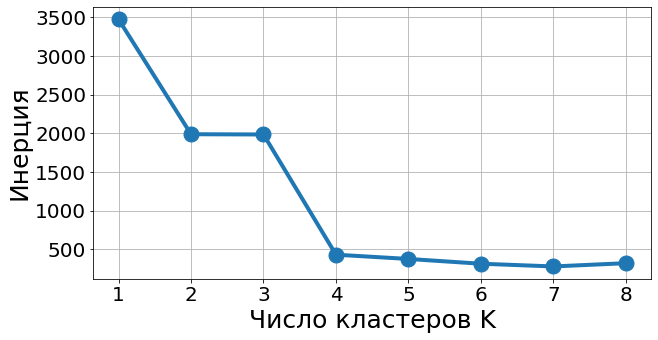

In [27]:
sse = []
list_k = list(range(1, 9))
for k in list_k:
    km = KMeans(n_clusters=k)
    km.fit(X_new)
    sse.append(km.inertia)

plt.figure(figsize=(10, 5))
plt.plot(list_k, sse, '-o',
         linewidth = 4, markersize = 15)
plt.xlabel('Число кластеров K', fontsize = 25)
plt.ylabel('Инерция', fontsize = 25)

plt.grid();
plt.xticks(FontSize = 20)
plt.yticks(FontSize = 20);

### Построение модели кластеризации

Зададим номера признаков, по которым будем строить модель

In [45]:
col_1 = 0

In [46]:
col_2 = 3

Создадим и обучим модель

Мы остановились на итерации: 7


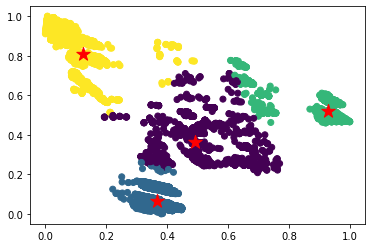

In [47]:
kmeans   = KMeans(n_clusters=4, max_iter=1000, tol=0.0001)
c_labels = kmeans.fit_transform(X_new[:,[col_1,col_2]])

print('Мы остановились на итерации:',kmeans.iters)

plt.scatter(X_new[:, col_1], X_new[:, col_2], c = c_labels)

plt.scatter(kmeans.centroids[:,0], kmeans.centroids[:,1],marker='*', s=200, c='red')

In [48]:
df['label'] = c_labels
df

,Признак 1,Признак 2,Признак 3,Признак 4,Признак 5,label
0,0.365497,0.032792,0.490341,0.134093,0.410604,1
1,0.376596,0.035428,0.471952,0.130307,0.433105,1
2,0.329276,0.034404,0.466159,0.033437,0.441844,1
3,0.376056,0.251108,0.497382,0.128952,0.431370,1
4,0.102705,0.457078,0.540355,0.783479,0.401750,3
...,...,...,...,...,...,...
19028,0.148058,0.034643,0.434648,0.772133,0.471108,3
19029,0.416021,0.044795,0.406626,0.116851,0.513030,1
19030,0.443448,0.047817,0.403780,0.030248,0.524535,1
19031,0.412192,0.045003,0.404715,0.116306,0.513350,1


Выведем количество значений по каждому кластеру

In [49]:
df['label'].value_counts()

1    9216
2    4154
3    3584
0    2079
Name: label, dtype: int64

In [33]:
#3    9216
#2    4154
#0    3584
#1    2079
#Name: label, dtype: int64

In [50]:
# до автоматизации руки не дошли, вручную правил
df['label'] = df['label'].map({1:0, 2:1,
                               3:2, 0:3})

In [51]:
df['label'].value_counts()

0    9216
1    4154
2    3584
3    2079
Name: label, dtype: int64

In [52]:
lab = df['label'].values

### Сохраним полученные метки кластеров в файл для выгрузки на платформу

In [53]:
submit = pd.read_csv('./Data/Kaggle3/Submission.csv')
submit

,idx,label
0,0,2
1,1,0
2,2,0
3,3,0
4,4,1
...,...,...
19028,19915,0
19029,19916,0
19030,19917,0
19031,19918,0


In [54]:
submit['label'] = lab
submit.head()

,idx,label
0,0,0
1,1,0
2,2,0
3,3,0
4,4,2


In [55]:
submit.to_csv('RIM120906_PopovMV_kaggle3_final.csv', index = False)

In [ ]:
# leaderboard 0.96621